In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from google.colab import drive
drive.mount('/content/drive')

# Seeds
import random, os
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

Mounted at /content/drive


'import random, os\ndef set_seed(seed=42):\n    random.seed(seed)\n    np.random.seed(seed)\n    torch.manual_seed(seed)\n    torch.cuda.manual_seed_all(seed)\n    os.environ["PYTHONHASHSEED"] = str(seed)\n    torch.backends.cudnn.deterministic = True\n    torch.backends.cudnn.benchmark = False\n\nset_seed(42)\n'

In [2]:
df_ibm = pd.read_csv("/content/drive/MyDrive/data/IBM.csv")

In [3]:
def preprocess_stock(df_raw, patch_len, train_frac, val_frac):
    df = df_raw.copy()

    # turn column to datetime, add helper day column
    df["Date Time"] = pd.to_datetime(df["Date Time"])
    df = df.sort_values("Date Time")
    df["day"] = df["Date Time"].dt.date

    # minutely log returns withing days from close
    # fill first minute with 0 returns
    df["log_close"] = np.log(df["Close"].astype(float))
    df["ret_1m"] = df.groupby("day")["log_close"].diff().fillna(0.0)

    # to check if each days actually has 381 return minutes
    day_return_count = df.groupby("day")["ret_1m"].size()
    print(day_return_count.value_counts())
    bars_mode = int(day_return_count.mode().iat[0]) # get mode of return minutes across dataset

    # compute daily RV
    daily = (df.groupby("day")["ret_1m"]
               .agg(rv=lambda x: np.sum(x**2))
               .reset_index())

    # in case there is a zero RV, replace it with small value before log
    daily["log_rv"] = np.log(daily["rv"].replace(0.0, 1e-12))
    # label for inputs from day d is log_rv of day d+1
    daily["log_rv_tplus1"] = daily["log_rv"].shift(-1)

    # create binary filter for days without valid target (prob just last day)
    valid_days = daily.dropna(subset=["log_rv_tplus1"])["day"]
    # remove them from both minute_df and daily_df
    df = df[df["day"].isin(valid_days)].copy()
    daily = daily[daily["day"].isin(valid_days)].reset_index(drop=True)

    # create minute index in each day
    df["idx_in_day"] = df.groupby("day").cumcount()

    # flag if we want to patch
    if patch_len == 1:
        # No patching: 1-minute tokens
        df["patch_id"] = df["idx_in_day"]
    # patch index inside day
    else:
        df["patch_id"] = (df["idx_in_day"] // patch_len).astype(int)

    # number of full patches per day (patches with len() == patch_len)
    tokens_full = (bars_mode // patch_len) if patch_len > 1 else bars_mode

     # collect aggregate information for each patch
    g = df.groupby(["day", "patch_id"])
    patch = g.agg(
        r_sum=("ret_1m", "sum"), # summed returns
        r_abs=("ret_1m", lambda x: np.abs(x).sum()), # summed absolute returns
        r_sq =("ret_1m", lambda x: np.sum(x**2)), # summed squared returns
        hi   =("High", "max"), # high
        lo   =("Low", "min"), # low
        vol  =("Volume", "sum"), # volumne
        r_last=("ret_1m", "last"), # last return
        n    =("ret_1m", "size"), # number of values (should be patch_len)
    ).reset_index()

    # drop the last not filled token
    patch = patch[patch["patch_id"] < tokens_full].copy()

    # robust log range
    # patch["range_hl"] = np.log(patch["hi"] / patch["lo"].replace(0, np.nan)).replace([np.inf, -np.inf], 0.0).fillna(0.0)
    # patch = patch.drop(columns=["hi", "lo"])



    # positional encoding

    # relative time-of-day encoding
    if tokens_full > 1:
        patch["pos"] = patch["patch_id"] / (tokens_full - 1)
    else:
        patch["pos"] = 0.0
    patch["pos_sin"] = np.sin(2 * np.pi * patch["pos"])
    patch["pos_cos"] = np.cos(2 * np.pi * patch["pos"])

    # calendar encoding
    # create small calendar daily index
    cal = patch[["day"]].drop_duplicates().copy()
    cal_dt = pd.to_datetime(cal["day"])

    # Day of Week
    dow = cal_dt.dt.weekday
    cal["dow_sin"] = np.sin(2 * np.pi * dow / 7.0)
    cal["dow_cos"] = np.cos(2 * np.pi * dow / 7.0)

    # Day of Month
    dom = cal_dt.dt.day
    cal["dom_sin"] = np.sin(2 * np.pi * dom / 31.0)
    cal["dom_cos"] = np.cos(2 * np.pi * dom / 31.0)

    # Month of Year
    moy = cal_dt.dt.month
    cal["moy_sin"] = np.sin(2 * np.pi * moy / 12.0)
    cal["moy_cos"] = np.cos(2 * np.pi * moy / 12.0)

    # Month-end flag
    cal["is_month_end"] = cal_dt.dt.is_month_end.astype(np.int8)

    # Attach calendar features to every patch in that day
    patch = patch.merge(cal, on="day", how="left")

    feat_cols = [
        "r_sum", "r_abs", "r_sq", "vol", "r_last",     # patch stats
        "pos_sin", "pos_cos",                                      # time-of-day
        "dow_sin", "dow_cos", "dom_sin", "dom_cos", "moy_sin", "moy_cos",  # calendar
        "is_month_end",                                            # flag (0/1)
    ]


    # ------------ BUILD X
    # get unique trading days, patch has one row for each patch
    day_list = sorted(patch["day"].unique())
    # initialize lists
    X_days, y_days = [], []
    # map each day to its target in a dict
    label_map = dict(zip(daily["day"], daily["log_rv_tplus1"]))

    # loop over trading days
    for d in day_list:
        # get all patches in one day sorted by time
        day_p = patch[(patch["day"] == d)].sort_values("patch_id")
        # skip days with not full patches
        if day_p.shape[0] != tokens_full:
            continue
        # turn features into numpy array of [Patch_len, n_features]
        # each Xi is a matrix representation of one trading day
        Xi = day_p[feat_cols].to_numpy(dtype=np.float32)            # [T_patches, d_features]
        # look up target for that day from dict
        yi = float(label_map[d])                                    # scalar target (log RV)
        X_days.append(Xi)
        y_days.append(yi)

    # stack data
    X = np.stack(X_days, axis=0)            # [N_days, T_tokens, d_in]
    y = np.array(y_days, dtype=np.float32)  # [N_days]



    # ------------- Train - Val - Test - Split
    # number of trading days in data set
    N = X.shape[0]
    # train split
    n_tr = int(N * train_frac)
    # val split
    n_va = int(N * val_frac)

    # comput split indices
    idx_tr = slice(0, n_tr)
    idx_va = slice(n_tr, n_tr + n_va)
    idx_te = slice(n_tr + n_va, N)

    # split data
    X_train, y_train = X[idx_tr], y[idx_tr]
    X_val, y_val = X[idx_va], y[idx_va]
    X_test, y_test = X[idx_te], y[idx_te]

    # ------------------- Scaling

    # only use train data for mean and sd
    # flattens across days and tokens
    mu = X_train.reshape(-1, X_train.shape[-1]).mean(axis=0, keepdims=True)   # [1, d_in], mean of each feature
    sd = X_train.reshape(-1, X_train.shape[-1]).std(axis=0, keepdims=True) + 1e-8 # sd of each feature

    def scale(arr):
        return (arr - mu) / sd

    X_train = scale(X_train)
    X_val = scale(X_val)
    X_test = scale(X_test)

    return {
        "X_train": X_train, "y_train": y_train,
        "X_val":   X_val, "y_val":   y_val,
        "X_test":  X_test, "y_test":  y_test,
        "meta": {
            "tokens_per_day": tokens_full,
            "feature_names": feat_cols,
            "bars_per_day_mode": bars_mode,
            "train_days": int(n_tr),
            "val_days": int(n_va),
            "test_days": int(N - n_tr - n_va),
            "scaler_mean": mu.astype(np.float32),
            "scaler_std": sd.astype(np.float32),
            "patch_len_minutes": patch_len,
        },
    }

In [4]:
def stack_context_days(X_days, y_days, context_window=22):
    N, T, d = X_days.shape # n_trading_days, tokens_per_day, features_per_token

    # initialize stack lists
    Xc, yc = [], []

    # slide rollwing window over dataset
    for i in range(N - context_window + 1):
        Xi = X_days[i:i+context_window].reshape(context_window * T, d)  # [seq_len, d]
        yi = y_days[i + context_window - 1]  # label aligned to last input day → predict next day

        # append sequence and length to lists
        Xc.append(Xi)
        yc.append(yi)

    # return stacked sequences
    return np.stack(Xc).astype(np.float32), np.array(yc, dtype=np.float32)

In [5]:
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

def mk_loader(X, y, bs=32, shuffle=False, num_workers=2):
    x_t = torch.tensor(X, dtype=torch.float32)
    y_t = torch.tensor(y, dtype=torch.float32)
    ds = TensorDataset(x_t, y_t)
    return DataLoader(ds, batch_size=bs, shuffle=shuffle, pin_memory=True, num_workers=num_workers)

In [6]:
class VolTransformerTiny(nn.Module):
    def __init__(self, d_in, d_model=128, nhead=4, num_layers=3, p_drop=0.1, use_cls=True, ff_mult=4):
        super().__init__()
        # flag for CLS
        self.use_cls = use_cls
        # input embedding 14 features -> d_model space
        self.embed = nn.Linear(d_in, d_model)

        # define one encoding layer
        enc_layer = nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=ff_mult*d_model,
                dropout=p_drop,
                batch_first=True,
                norm_first=True
            )

        # stack several encoder layers
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)

        # CLS token
        if use_cls:
            self.cls = nn.Parameter(torch.zeros(1, 1, d_model))
            # init with random values, becomes summary token
            nn.init.normal_(self.cls, mean=0.0, std=0.02)

        # predition head
        self.head = nn.Sequential(
            # stabilize final embedding
            nn.LayerNorm(d_model),
            nn.Dropout(p_drop),
            # next day log RV prediction
            nn.Linear(d_model, 1)
        )

    # how does data flow through model
    # B = batch size 32
    # L = sequence length 550 tokens for 22 day context
    # d_in = features per token, here 14
    def forward(self, x):              # x: [B,L,d_in]
        # apply embed projection
        h = self.embed(x)

        if self.use_cls:
            # now first token in each sequence is CLS
            cls = self.cls.expand(h.size(0), -1, -1)
            h = torch.cat([cls, h], dim=1)
        # start encoder
        h = self.encoder(h)
        # if CLS, take first token for pred, else mean of tokens
        pooled = h[:,0] if self.use_cls else h.mean(dim=1)

        # one vec per seq
        return self.head(pooled).squeeze(-1)

In [7]:
# Training loop
def train_model(Xtr, ytr, Xva, yva, *,
                d_model=128, nhead=4, num_layers=3,
                batch_size=32, lr=1e-3, max_epochs=50, weight_decay=1e-2,
                p_drop=0.1):

    # data loaders
    train_loader = mk_loader(Xtr, ytr, bs=batch_size, shuffle=True)
    val_loader   = mk_loader(Xva, yva, bs=batch_size, shuffle=False)

    # create instance of Transformer, move to CUDA
    model = VolTransformerTiny(d_in=Xtr.shape[-1], d_model=d_model, nhead=nhead, num_layers=num_layers).cuda()
    # ADAM
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    # loss function
    loss_fn = nn.MSELoss()

    #
    for epoch in range(1, max_epochs+1):

        # --- train ---
        # set model to training mode
        model.train()
        train_loss=0
        n=0

        # iterate over train batches
        for xb,yb in tqdm(train_loader, desc=f"Epoch {epoch}/{max_epochs}", leave=False):
            # move to CUDA
            xb,yb=xb.cuda(),yb.cuda()
            # reset gradients
            opt.zero_grad()
            # run forward pass
            pred=model(xb)
            loss=loss_fn(pred,yb)
            # backward pass
            loss.backward()
            # clip gradients if l2 > 1.0, prevent exploding gradients
            # stable training
            nn.utils.clip_grad_norm_(model.parameters(),1.0)
            # update optimizer
            opt.step()
            # adjust loss, counter
            train_loss+=loss.item()*xb.size(0)
            n+=xb.size(0)
        # compute average training loss
        train_loss/=n

        # --- val ---
        # set model to evaluation mode
        model.eval()
        val_loss=0
        n=0
        # disable gradient computing, dont need backward validation
        with torch.no_grad():
            # iterate over validation
            for xb,yb in val_loader:
                # move to CUDA
                xb,yb=xb.cuda(),yb.cuda()
                # forward model pass
                pred=model(xb)
                # calculate loss
                loss=loss_fn(pred,yb)
                val_loss+=loss.item()*xb.size(0)
                n+=xb.size(0)
        # average loss
        val_loss/=n

        print(f"Epoch {epoch:03d} | Train {train_loss:.6f} | Val {val_loss:.6f}")
    return model

In [8]:
out = preprocess_stock(df_ibm, patch_len=15, train_frac=0.7, val_frac=0.15)
Xtr_ctx, ytr_ctx = stack_context_days(out["X_train"], out["y_train"], context_window=22)
Xva_ctx, yva_ctx = stack_context_days(out["X_val"],   out["y_val"],   context_window=22)
Xte_ctx, yte_ctx = stack_context_days(out["X_test"],  out["y_test"],  context_window=22)

ret_1m
381    2516
Name: count, dtype: int64


In [9]:
# Train the model
model = train_model(
    Xtr_ctx, ytr_ctx, Xva_ctx, yva_ctx,
    d_model=128, nhead=4, num_layers=3,
    batch_size=32, lr=1e-3, max_epochs=50
)

# Evaluate on validation and test
import torch, numpy as np
loss_fn = torch.nn.MSELoss()

def eval_mse(X, y, bs=32):
    loader = mk_loader(X, y, bs=bs, shuffle=False)
    model.eval()
    tot, n = 0.0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.cuda(), yb.cuda()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            tot += loss.item() * xb.size(0)
            n += xb.size(0)
    return tot / max(1, n)

val_mse = eval_mse(Xva_ctx, yva_ctx)
te_mse  = eval_mse(Xte_ctx, yte_ctx)
print(f"Val MSE (logRV): {val_mse:.6f} | Test MSE (logRV): {te_mse:.6f}")

# Get all test predictions
def predict_array(X, bs=32):
    loader = mk_loader(X, np.zeros(len(X), dtype=np.float32), bs=bs, shuffle=False)
    preds = []
    model.eval()
    with torch.no_grad():
        for xb, _ in loader:
            xb = xb.cuda()
            preds.append(model(xb).cpu().numpy())
    return np.concatenate(preds, axis=0)

yte_pred_log = predict_array(Xte_ctx)          # predicted log(RV)
yte_true_log = yte_ctx                         # true log(RV)

# save model
import torch
torch.save(model.state_dict(), "vol_transformer_tiny.pt")
print("Saved to vol_transformer_tiny.pt")


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 1/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 001 | Train 5.467542 | Val 0.501997


Epoch 2/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 002 | Train 0.417585 | Val 0.505333


Epoch 3/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 003 | Train 0.404292 | Val 0.459862


Epoch 4/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 004 | Train 0.405087 | Val 0.408905


Epoch 5/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 005 | Train 0.362689 | Val 0.424129


Epoch 6/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 006 | Train 0.374382 | Val 0.402907


Epoch 7/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 007 | Train 0.368157 | Val 0.422729


Epoch 8/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 008 | Train 0.347957 | Val 0.466122


Epoch 9/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 009 | Train 0.340397 | Val 0.494043


Epoch 10/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 010 | Train 0.352354 | Val 0.425993


Epoch 11/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 011 | Train 0.335615 | Val 0.429519


Epoch 12/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 012 | Train 0.323117 | Val 0.410117


Epoch 13/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 013 | Train 0.312678 | Val 0.445293


Epoch 14/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 014 | Train 0.323994 | Val 0.445839


Epoch 15/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 015 | Train 0.312611 | Val 0.543983


Epoch 16/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 016 | Train 0.319955 | Val 0.464372


Epoch 17/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 017 | Train 0.306929 | Val 0.443230


Epoch 18/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 018 | Train 0.315089 | Val 0.469377


Epoch 19/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 019 | Train 0.327451 | Val 0.523153


Epoch 20/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 020 | Train 0.330410 | Val 0.534399


Epoch 21/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 021 | Train 0.308464 | Val 0.411010


Epoch 22/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 022 | Train 0.323784 | Val 0.496619


Epoch 23/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 023 | Train 0.323313 | Val 0.541247


Epoch 24/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 024 | Train 0.303343 | Val 0.449274


Epoch 25/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 025 | Train 0.307098 | Val 0.444518


Epoch 26/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 026 | Train 0.310081 | Val 0.421105


Epoch 27/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 027 | Train 0.310553 | Val 0.488022


Epoch 28/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 028 | Train 0.304229 | Val 0.500504


Epoch 29/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 029 | Train 0.299826 | Val 0.483637


Epoch 30/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 030 | Train 0.314765 | Val 0.437855


Epoch 31/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 031 | Train 0.298968 | Val 0.430783


Epoch 32/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 032 | Train 0.324156 | Val 0.411678


Epoch 33/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 033 | Train 0.298951 | Val 0.460671


Epoch 34/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 034 | Train 0.274165 | Val 0.437102


Epoch 35/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 035 | Train 0.299838 | Val 0.467530


Epoch 36/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 036 | Train 0.294065 | Val 0.413218


Epoch 37/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 037 | Train 0.274394 | Val 0.442661


Epoch 38/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 038 | Train 0.281612 | Val 0.464066


Epoch 39/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 039 | Train 0.292223 | Val 0.440321


Epoch 40/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 040 | Train 0.274702 | Val 0.422865


Epoch 41/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 041 | Train 0.277512 | Val 0.439310


Epoch 42/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 042 | Train 0.283051 | Val 0.465399


Epoch 43/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 043 | Train 0.275639 | Val 0.430693


Epoch 44/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 044 | Train 0.278182 | Val 0.438948


Epoch 45/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 045 | Train 0.285216 | Val 0.472913


Epoch 46/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 046 | Train 0.278641 | Val 0.424042


Epoch 47/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 047 | Train 0.289868 | Val 0.463878


Epoch 48/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 048 | Train 0.276600 | Val 0.462257


Epoch 49/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 049 | Train 0.315089 | Val 0.416962


Epoch 50/50:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 050 | Train 0.266039 | Val 0.441874
Val MSE (logRV): 0.441874 | Test MSE (logRV): 0.437921
Saved to vol_transformer_tiny.pt


In [21]:
y_naive[:10]

array([-10.283623,  -9.913792,  -8.547823,  -9.777274, -10.394844,
       -10.876617, -10.482609, -10.181636, -10.177388, -10.155936],
      dtype=float32)

In [47]:
y_true[:10]

array([-10.283623,  -9.913792,  -8.547823,  -9.777274, -10.394844,
       -10.876617, -10.482609, -10.181636, -10.177388, -10.155936],
      dtype=float32)

In [48]:
yte_true_log[:10]

array([-10.283623,  -9.913792,  -8.547823,  -9.777274, -10.394844,
       -10.876617, -10.482609, -10.181636, -10.177388, -10.155936],
      dtype=float32)

In [46]:
y_naive[:10]

array([ -9.913792,  -8.547823,  -9.777274, -10.394844, -10.876617,
       -10.482609, -10.181636, -10.177388, -10.155936,  -9.705507],
      dtype=float32)

Naive baseline Test MSE (logRV): 0.265479
Transformer Test MSE (logRV): 0.437921


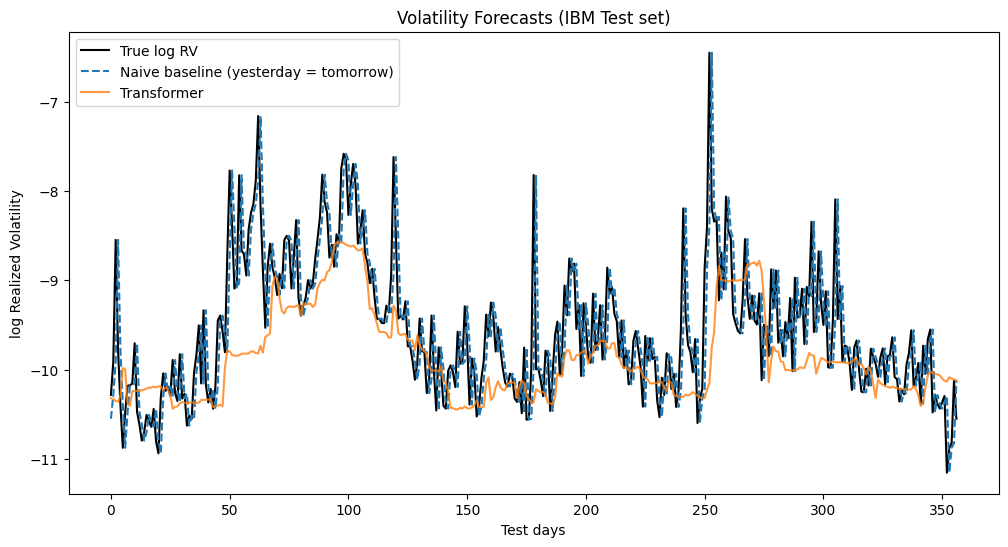

In [12]:
y_naive = np.roll(yte_true_log, 1)
y_true  = yte_true_log
naive_mse = np.mean((y_naive - y_true)**2)
#naive_mse = np.mean((y_naive - yte_true_log)**2)
print(f"Naive baseline Test MSE (logRV): {naive_mse:.6f}")
print(f"Transformer Test MSE (logRV): {te_mse:.6f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(yte_true_log, label="True log RV", color="black")
plt.plot(y_naive, label="Naive baseline (yesterday = tomorrow)", linestyle="--")
plt.plot(yte_pred_log, label="Transformer", alpha=0.8)
plt.title("Volatility Forecasts (IBM Test set)")
plt.xlabel("Test days")
plt.ylabel("log Realized Volatility")
plt.legend()
plt.show()


In [29]:

print(y_naive[0], yte_true_log[0])

-10.283623 -10.283623


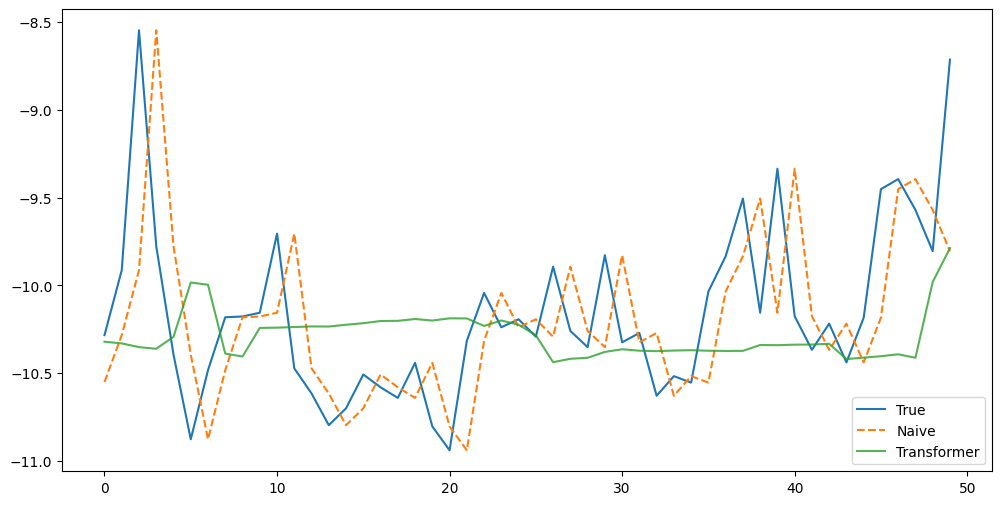

In [13]:

plt.figure(figsize=(12,6))
plt.plot(yte_true_log[:50], label="True")
plt.plot(y_naive[:50], label="Naive", linestyle="--")
plt.plot(yte_pred_log[:50], label="Transformer", alpha=0.8)
plt.legend(); plt.show()
